In [12]:
!/opt/bin/nvidia-smi

Fri Nov 13 12:43:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   1053MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!rm -rf /content/sample_data
!rm -rf /content/MNIST_cGAN_results
!rm -rf /content/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
# G(z)

class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.fc1_1 = nn.Linear(100, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 784)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.tanh(self.fc4(x))

        return x

In [ ]:
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1_1 = nn.Linear(784, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.fc1_1(input), 0.2)
        y = F.leaky_relu(self.fc1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = F.sigmoid(self.fc4(x))

        return x


In [ ]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [18]:
temp_z_ = torch.rand(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)

for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10,1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

# fixed_z_.shape: 100*100 noise
# fixed_y_.shape: 100*1 0-9各十个标签

fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
with torch.no_grad():
    fixed_z_ = Variable(fixed_z_.cuda())
    fixed_y_label_ = Variable(fixed_y_label_.cuda())

# fixed_y_label: 100*10 0-9各10个one-hot形式的label


torch.Size([100, 10])


In [ ]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 50

# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# network
G = generator()
D = discriminator()
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)
G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_cGAN_results'):
    os.mkdir('MNIST_cGAN_results')
if not os.path.isdir('MNIST_cGAN_results/Fixed_results'):
    os.mkdir('MNIST_cGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

training start!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/50] - ptime: 16.67, loss_d: 0.866, loss_g: 1.247
[2/50] - ptime: 16.41, loss_d: 0.252, loss_g: 2.570
[3/50] - ptime: 16.34, loss_d: 0.113, loss_g: 3.602
[4/50] - ptime: 16.38, loss_d: 0.055, loss_g: 4.251
[5/50] - ptime: 16.69, loss_d: 0.054, loss_g: 4.510
[6/50] - ptime: 16.23, loss_d: 0.050, loss_g: 4.840
[7/50] - ptime: 16.48, loss_d: 0.016, loss_g: 5.355
[8/50] - ptime: 16.51, loss_d: 0.038, loss_g: 5.378
[9/50] - ptime: 16.66, loss_d: 0.020, loss_g: 5.652
[10/50] - ptime: 16.58, loss_d: 0.028, loss_g: 5.784
[11/50] - ptime: 16.37, loss_d: 0.006, loss_g: 6.210
[12/50] - ptime: 16.48, loss_d: 0.014, loss_g: 6.557
[13/50] - ptime: 16.58, loss_d: 0.032, loss_g: 6.252
[14/50] - ptime: 16.40, loss_d: 0.020, loss_g: 5.923
[15/50] - ptime: 16.43, loss_d: 0.004, loss_g: 6.657
[16/50] - ptime: 16.59, loss_d: 0.022, loss_g: 6.439
[17/50] - ptime: 16.70, loss_d: 0.002, loss_g: 7.092
[18/50] - ptime: 16.44, loss_d: 0.002, loss_g: 7.453
[19/50] - ptime: 16.42, loss_d: 0.001, loss_g: 7.691
[2

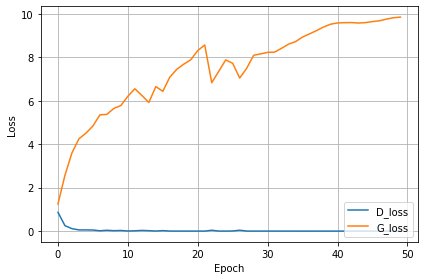

In [ ]:
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) == 30:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 40:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    for x_, y_ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        x_ = x_.view(-1, 28 * 28)
        x_, y_label_, y_real_, y_fake_ = \
            Variable(x_.cuda()), Variable(y_label_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_, y_label_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.rand((mini_batch, 100))
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        z_, y_label_ = Variable(z_.cuda()), Variable(y_label_.cuda())
        G_result = G(z_, y_label_)

        D_result = D(G_result, y_label_).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.rand((mini_batch, 100))
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        z_, y_label_ = Variable(z_.cuda()), Variable(y_label_.cuda())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_label_).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), \
              train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = 'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % \
      (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_cGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_cGAN_results/discriminator_param.pkl")
with open('MNIST_cGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist,show=True, save=True, path='MNIST_cGAN_results/MNIST_cGAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = 'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_cGAN_results/generation_animation.gif', images, fps=10)